# Reinforcement learning introduction

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward
* *Q*: prediction of likely/possible long-term reward of an *action*
* *Model* (optional): a simulation of the environment

### Types of model

* *Model-based*: have model of environment (e.g. a board game)
* *Model-free*: used when environment not fully known
* *Policy-based*: identify best policy directly
* *Value-based*: estimate value of a decision
* *Off-policy*: can learn from historic data from other agent
* *On-policy*: requires active learning from current decisions

## Requirements

AI-gym: `pip install gym gym[atari]`

PyTorch: see https://pytorch.org/get-started/locally/

# AI Gym

Gym (from OpenAI: https://openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

https://gym.openai.com/

AI gym has a standard interface. An action is transfered with step, and this returns:

* *obs*: New observation
* *reward*: reward from action
* *done*: 'True' if game over
* *info*: A dictionary of extra information (game dependent)

The syntax is:

`obs, reward, done, info = env.step(action)`

## CartPole

CartPole is one of the simplest environments. A pole is attached by a joint to a cart, which moves along a track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity (left or right).

https://gym.openai.com/envs/CartPole-v1/
https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

A simple video here:

https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CartPole-v1/original.mp4

In [1]:
"""
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along a
    frictionless track. The pendulum starts upright, and the goal is to prevent
    it from falling over by increasing and reducing the cart's velocity.
Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson
    
Observation: 
    Type: Box(4)
    Num	Observation                 Min         Max
    0	Cart Position             -4.8            4.8
    1	Cart Velocity             -Inf            Inf
    2	Pole Angle                 -24 deg        24 deg
    3	Pole Velocity At Tip      -Inf            Inf

Actions:
    Type: Discrete(2)
    Num	Action
    0	Push cart to the left
    1	Push cart to the right

Note: The amount the velocity that is reduced or increased is not fixed; 
it depends on the angle the pole is pointing. This is because the center of 
gravity of the pole increases the amount of energy needed to move the cart 
underneath it.

Reward:
    Reward is 1 for every step taken, including the termination step

Starting State:
    All observations are assigned a uniform random value in [-0.05..0.05]
Episode Termination:
    Pole Angle is more than 12 degrees
    Cart Position is more than 2.4 (center of the cart reaches the edge of the
      display)
    Episode length is greater than 200
    Solved Requirements
    Considered solved when the average reward is greater than or equal to 195.0
      over 100 consecutive trials.
""";

An example of setting up CartPole, getting first observation, and taking an action.

In [2]:
import gym
# Set up environment and import first observation
env = gym.make("CartPole-v1")
obs = env.reset()
print ('Starting obs:', obs)

# Take action 1 (push cart to right and get new observation)
print ('\nTake action (push cart to right):')
action = 1
obs, reward, done, info = env.step(action)
print('\nNew observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Extra info:', info)

Starting obs: [ 0.03632796  0.00264805  0.00960607 -0.00878697]

Take action (push cart to right):

New observation: [ 0.03638092  0.19763093  0.00943033 -0.29842365]
Reward: 1.0
Done: False
Extra info: {}


# Reinforcement Learning: Cartpole cross-entropy

*Cross entropy* in neural nets provides probabilities across any number of classifications.

*Cross entropy* RL is a model-free policy-based (on-policy) method. It is based on learning from previous best runs. For each observation the nn provides a probability of action to be taken. Use of sampling and probability allows exploration.

Method steps:

* Play n episodes using current model and environment
* Calculate total reward for each episode
* Keep best episodes (e.g. top 30%-50%)
* Train on best episodes using observations and actions taken
* Repeat

### Import modules

In [3]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### set up variables

In [4]:
DISPLAY_GAME = False
LEARNING_RATE = 0.003

### The cross-entropy neural net

In [5]:
class Net(nn.Module):
    """
    Pytorch neural net using the flexible pytorch nn.Modlule class.
    Note: the neural net output is linear. To convert these to probabilities for
    each action (sum to 1.0) a SoftMax activation on the final output is 
    required, but this is applied outside of the net itself, which improves
    speed and stability of training.
    
    Layers in model:
    * Input layer (implied, takes the number of observations)
    * 48 node layer
    * ReLU activation
    * 24 node layer
    * ReLU activation
    * Output layer (size = number of possible actions)
    
    (A SoftMax layer will be added later)
    """
    
    def __init__(self, observation_space, action_space):
        """Define layers of sequential net"""
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, action_space)
    )

    def forward(self, x):
        """Define forward pass (simple, as using a pre-defined sequential
        model)"""
        return self.net(x)

### Function to play a single episode

In [6]:
def play_episode(env, model, observation_space):
    """Play an episode"""
    
    # Define softmax layer
    sm = nn.Softmax(dim=1) 
    
    # Reset trackers and environment
    episode_reward = 0
    obs_tracker = []
    action_tracker = []
    
    # Reset environment (returns first observation)
    obs = env.reset()
    
    # Loop up to 200 steps
    for step in range(200):
        
        # Show game step (will slow game, but useful to watch at least once)
        if DISPLAY_GAME:
            env.render()
            
        # Track observations
        obs = np.float32(obs)
        obs_tracker.append(obs)
        
        # Get action probability (put obs in Tensor first)
        obs = torch.FloatTensor([obs])
        act_probs = model(obs)
        act_probs = sm(act_probs)
        act_probs = act_probs.data.numpy()[0]
        
        # Get and track action: action sampled based on probability distribution
        action = np.random.choice(len(act_probs), p=act_probs)
        action_tracker.append(action)
        
        # Take action
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        # Pole has fallen over if done is True
        if done:
            break
     
    # Put results in dictionary
    results = {'episode_reward': episode_reward,
               'episode_obs': obs_tracker,
               'episode_actions': action_tracker}

    return results

### Function to filter best episodes

In [7]:
def filter_episodes(results, percentile_cutoff = 70):
    """Get best episodes"""
    
    # Get episode rewards & define cuttoff
    episode_rewards = [episode['episode_reward'] for episode in results]
    reward_cutoff = np.percentile(episode_rewards, percentile_cutoff)
    
    # Get best episode observations and actions
    obs = [episode['episode_obs'] for episode in results if 
           episode['episode_reward'] >= reward_cutoff]
    
    actions = [episode['episode_actions'] for episode in results if 
               episode['episode_reward'] >= reward_cutoff]
    

    # Convert list of observation arrays into a numpy array
    obs = np.vstack(obs)
    
    # Flatten actions list and convert to NumPy
    actions = [item for sublist in actions for item in sublist]
    actions = np.array(actions)    
 
    return obs, actions

### Function to plot results

In [8]:
def plot_results(batch, average, best):
    """Line plot of average and best rewards over time"""
    
    plt.plot(batch, average, label='Average batch reward')
    plt.plot(batch, best, label='Best batch reward')
    plt.xlabel('Batch')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

### Main program

The main program:

* Sets up model
* Continues a loop of playing batches and episodes and training net until goal achieved.
    * Play batch of episodes
    * Select best episodes
    * Train neural net

In [9]:
def main():
    
    ############################## Set up model ################################
    
    # Set target (average batch reward, max for CartPole is 200)
    target = 200
    
    # Set number of episodes to play before slecting best and updating net
    episode_batch_size = 10
    
    # Set up environment
    env = gym.make("CartPole-v1")
    
    # Get number of observations from environemt(allows the env to change)
    obs_size = env.observation_space.shape[0]
    
    # Get number of actins from environemnt
    n_actions = env.action_space.n
    
    # Set up Neural Net
    model = Net(obs_size, n_actions)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    # Play batches of episodes 
    batch_count = 0
    
    # Lists to store results
    all_results_batch_number = []
    all_results_average_reward = []
    all_results_maxumum_reward = []
    
    # Start playing loop and continue until goal performance reached
    while True:
        
        ############## Play batch of epsiodes and select best ##################
        
        # Play episodes 
        batch_count += 1
        batch_results = []
        for episode in range(episode_batch_size):
            results = play_episode(env, model, obs_size)
            batch_results.append(results)
            
        # Get average and maximum reward
        rewards = [episode['episode_reward'] for episode in batch_results]
        average_reward = np.mean(rewards)
        maximum_reward = np.max(rewards)
        
        # Store results
        all_results_batch_number.append(batch_count)
        all_results_average_reward.append(average_reward)
        all_results_maxumum_reward.append(maximum_reward)
        
        print (f'\rBatch {batch_count:3}. Average and best run: ' \
               f'{average_reward:3.1f}, {maximum_reward:3.1f}', end="")
        
        # Check whether goal reached (and break loop)
        if average_reward >= target:
            print ('\nGoal achieved')
            break
        
        # Get best runs
        training_obs, training_actions = filter_episodes(batch_results)  
        training_obs = torch.Tensor(training_obs)
        training_actions = torch.Tensor(training_actions).long()
        
        ########################### Train model ################################
        
        # Reset model gradients
        optimizer.zero_grad()
        # Predict actions
        action_scores = model(training_obs)
        # Calculate loss between predicted and actual actions
        loss_v = objective(action_scores, training_actions)
        # Back propgate losses
        loss_v.backward()
        # Update model weights
        optimizer.step()
        
        
    # Plot results
    plot_results(all_results_batch_number, all_results_average_reward, 
                 all_results_maxumum_reward)

Batch 112. Average and best run: 200.0, 200.0
Goal achieved


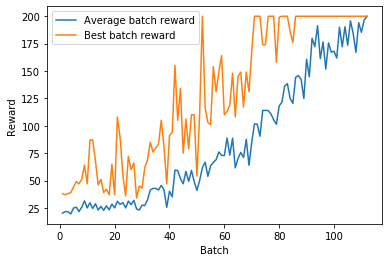

In [10]:
main()